# Square Trade - IMF Data

### Basic Python Analysis

First, import dependencies.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression as lr

Load and parse dataframe in it's raw, wide format. We want to create a format that is easy both easy to manipulate in Python for graphing and analysis here, and also for more self-service tools like Tableau. To do this we'll melt the frame.

In [2]:
raw_frame = pd.read_excel('Detailed_Revenue_Breakdown.xlsx', skiprows=7, engine='openpyxl')
raw_frame = raw_frame.rename(columns={'Unnamed: 0' : 'revenue_source'})
raw_frame.head(10)

,revenue_source,1997,1998,1999,2000,2001,2002,2003,2004,2005,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,Unnamed: 24
0,Revenue,297.481,324.043,343.899,370.995,382.659,387.302,408.873,445.966,486.964,...,576.697,597.172,622.932,636.810,660.991,696.813,734.476,758.657,784.262,NaN
1,Taxes,225.764,249.362,265.337,286.704,292.457,296.600,308.677,332.249,356.159,...,428.949,429.294,446.797,463.464,479.974,506.975,530.781,548.734,561.718,NaN
2,"Taxes on income, profits, & capital gains",107.734,123.683,129.552,143.608,146.418,143.742,148.082,162.876,182.434,...,204.221,198.391,203.286,208.854,216.704,232.460,244.490,252.019,257.169,NaN
3,"Taxes on income, profits, & capital gains: ind...",75.598,89.534,96.683,105.340,111.904,112.176,115.970,124.084,134.611,...,157.670,153.796,159.112,162.783,171.446,179.113,187.896,194.826,203.385,NaN
4,"Taxes on income, profits, & capital gains: cor...",32.136,34.149,32.869,38.268,34.514,31.566,32.112,38.792,47.823,...,46.551,44.595,44.174,46.071,45.258,53.347,56.594,57.193,53.784,NaN
5,"Taxes on income, profits, & capital gains: other",0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,NaN
6,Taxes on payroll & workforce,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,1.842,2.604,2.764,NaN
7,Taxes on property,15.732,16.284,17.236,18.839,19.862,20.894,21.035,21.826,23.054,...,28.337,29.836,31.847,31.926,33.120,34.249,35.686,36.663,37.086,NaN
8,Taxes on goods & services,102.298,109.395,118.549,124.257,126.177,131.928,139.511,147.497,150.621,...,193.599,198.680,208.224,218.960,225.918,236.171,245.060,253.468,260.641,NaN
9,General taxes on goods & services,57.950,61.520,68.182,73.285,75.252,79.479,85.647,91.550,94.540,...,122.292,125.377,133.190,141.716,146.739,153.556,159.756,165.907,170.761,NaN


Grab the column names from the frame, we'll use this column list to easily select the columns we want to melt. We'll also create lists of the categories and sub-categorys in the raw frame for use later.

In [3]:
column_list = list(raw_frame.columns.tolist())
conditions_cat = []
conditions_sub_cat = []
category_types = ['Revenue',
                  'Other revenue',
                  'Taxes',
                  'Social contributions',
                  'Grants',
                  ]

sub_category_types = ['Taxes on income, profits, & capital gains',
                      'Taxes on goods & services',
                      'Grants from other gen govt',
                      'Excise taxes',
                      ]


Now we melt the frame into a tidy format, with each row being an event split into distinct variables and observations.

In [4]:
melted_frame = pd.melt(raw_frame, id_vars=['revenue_source'], value_vars=column_list[1:], var_name='year')
melted_frame = melted_frame[melted_frame['year'] != 'Unnamed: 24']
melted_frame.head(10)

,revenue_source,year,value
0,Revenue,1997,297.481
1,Taxes,1997,225.764
2,"Taxes on income, profits, & capital gains",1997,107.734
3,"Taxes on income, profits, & capital gains: ind...",1997,75.598
4,"Taxes on income, profits, & capital gains: cor...",1997,32.136
5,"Taxes on income, profits, & capital gains: other",1997,0.000
6,Taxes on payroll & workforce,1997,0.000
7,Taxes on property,1997,15.732
8,Taxes on goods & services,1997,102.298
9,General taxes on goods & services,1997,57.950


However, the overarching category totals are now mixed into our tidy data. So let's create a new column to include them as variables. To do this, we use our category (and subcategory) lists to create lists of boolean expressions that check what category each row is in.

In [5]:
for category in category_types[2:]:
    conditions_cat.append(melted_frame['revenue_source'].str.contains(category.split()[0], case=False, regex=False))

for sub_category in sub_category_types:
    conditions_sub_cat.append(melted_frame['revenue_source'].str.contains(sub_category, case=False, regex=False))
    
outcomes_cat = ['Taxes',
                'Social Contributions',
                'Grants',
                ]

outcomes_subcat = ['Taxes on income, profits, & capital gains',
                   'Taxes on goods & services',
                   'Grants from other gen govt',
                   'Taxes on goods & services',
                   ]

We then use these boolean lists to create our new variable columns, and remove the category rows.

In [6]:
melted_frame['category'] = np.select(conditions_cat, outcomes_cat, default='Other')
melted_frame['sub_category'] = np.select(conditions_sub_cat, outcomes_subcat, default=np.nan)
melted_frame = melted_frame[~melted_frame['revenue_source'].isin(category_types)]
melted_frame = melted_frame[~melted_frame['revenue_source'].isin(sub_category_types[:3])]

melted_frame.tail(10)

,revenue_source,year,value,category,sub_category
631,Other social contributions,2019,34.400,Social Contributions,nan
633,Grants from foreign govts,2019,0.041,Grants,nan
634,Grants from int orgs,2019,0.029,Grants,nan
636,Grants from other gen govt: current,2019,0.000,Grants,Grants from other gen govt
637,Grants from other gen govt: capital,2019,0.405,Grants,Grants from other gen govt
639,Property income,2019,19.932,Other,nan
640,Sales of goods & services,2019,18.780,Other,nan
641,"Fines, penalties & forfeits",2019,0.000,Other,nan
642,Other transfers,2019,5.503,Other,nan
643,"NI & SGS: premiums, fees & claims",2019,0.462,Other,nan


We can then easily group our variables at any level we wish.

In [7]:
category_group = melted_frame.groupby(['year', 'category']).sum()
category_group

value
year category                     
1997 Grants                  0.006
     Other                  12.096
     Social Contributions   59.615
     Taxes                 214.810
1998 Grants                  0.007
...                            ...
2018 Taxes                 525.042
2019 Grants                  0.475
     Other                  44.677
     Social Contributions  177.392
     Taxes                 537.051

[92 rows x 1 columns]

So lets look into the data at the category level, looks like the majority of the UK's revenue growth comes from the increase in Taxation Revenue, followed by Social Contributions.

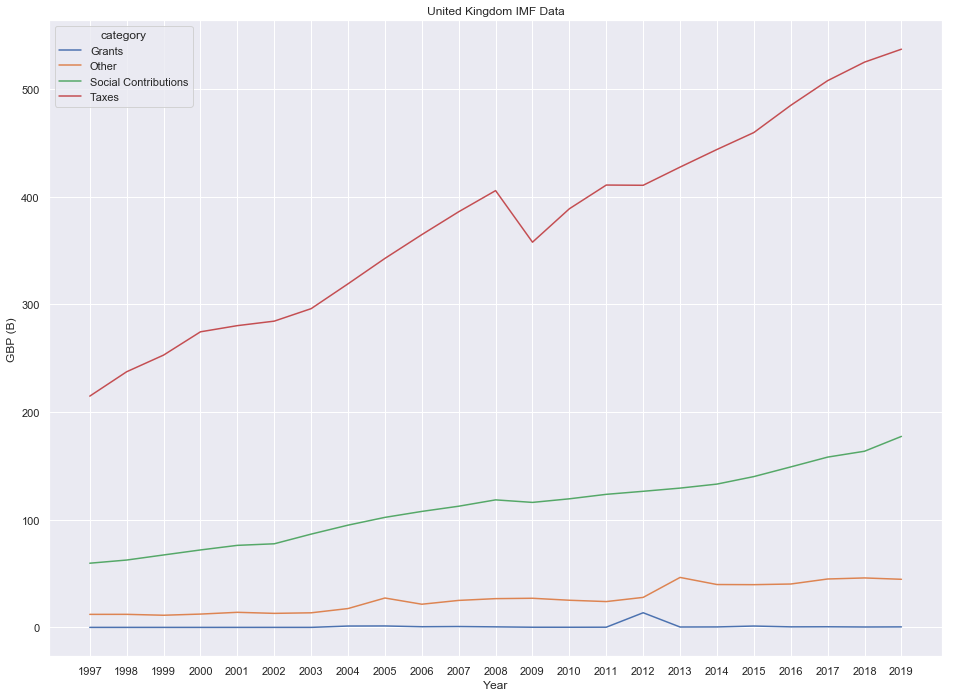

In [8]:
sns.set(rc={'figure.figsize':(16,11.7)})
sns.set_style('darkgrid')
g = sns.lineplot(x='year', y='value', hue='category', data=category_group)
g.set(xlabel='Year', ylabel='GBP (B)', title='United Kingdom IMF Data')
g

Digging into the tax revenue a little, we can see that the citizen/individual taxation as well as goods and services has grown massively. While corporate taxation has maintained a rather low growth rate over time.

[Text(0,0.5,'GBP (B)'),
 Text(0.5,0,'Year'),
 Text(0.5,1,'United Kingdom IMF Data - Taxes only')]

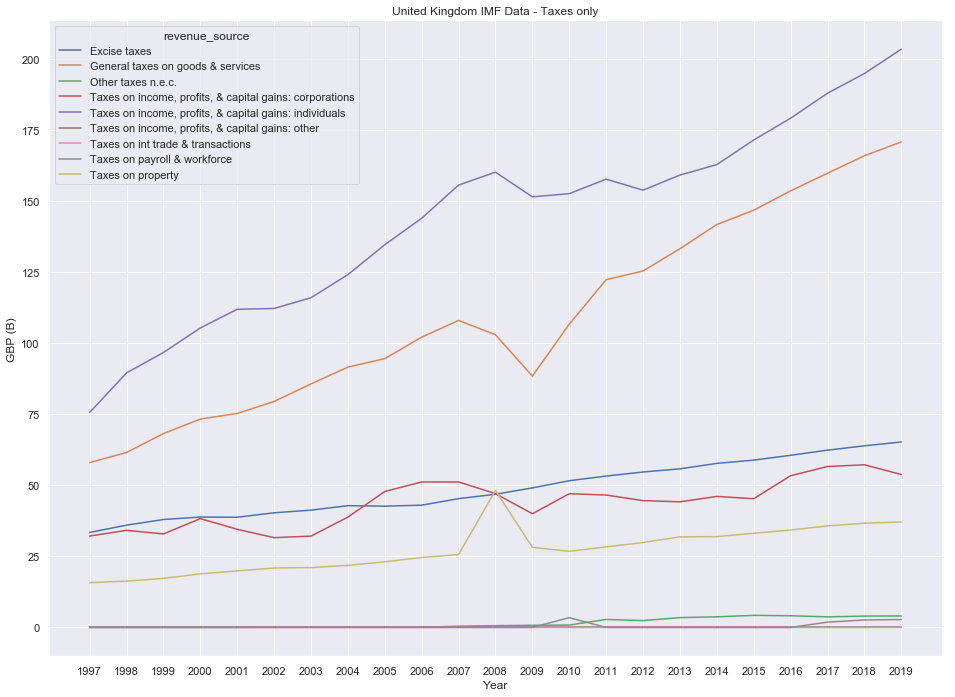

In [9]:
sub_category_group = melted_frame[melted_frame['category'] == 'Taxes'].groupby(['year', 'revenue_source']).sum()
g = sns.lineplot(x='year', y='value', hue='revenue_source', data=sub_category_group)
g.set(xlabel='Year', ylabel='GBP (B)', title='United Kingdom IMF Data - Taxes only')

We see a similar story when we include social contributions.

[Text(0,0.5,'GBP (B)'),
 Text(0.5,0,'Year'),
 Text(0.5,1,'United Kingdom Individual vs Corporate Revenues')]

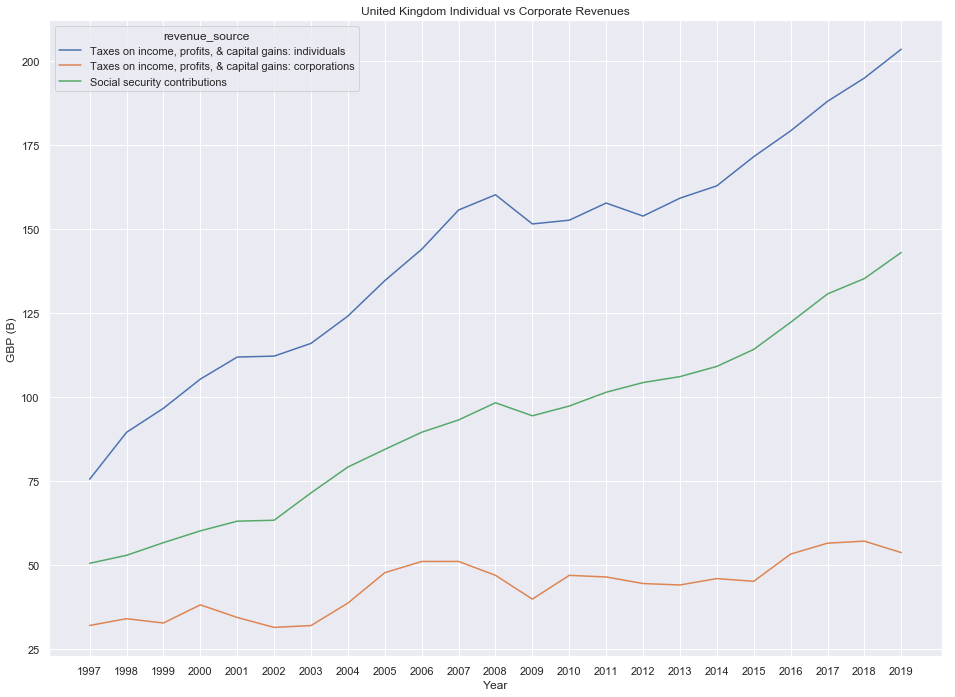

In [10]:
larger_growers = ['Taxes on income, profits, & capital gains: individuals', 'Social security contributions', 'Taxes on income, profits, & capital gains: corporations']

sub_category_group = melted_frame[melted_frame['revenue_source'].isin(larger_growers)]
g = sns.lineplot(x='year', y='value', hue='revenue_source', data=sub_category_group)
g.set(xlabel='Year', ylabel='GBP (B)', title='United Kingdom Individual vs Corporate Revenues')

Looks like a good first step to present in Tableau. Finally let's compare the growth from 1997 to 2019 for each of these revenue streams.

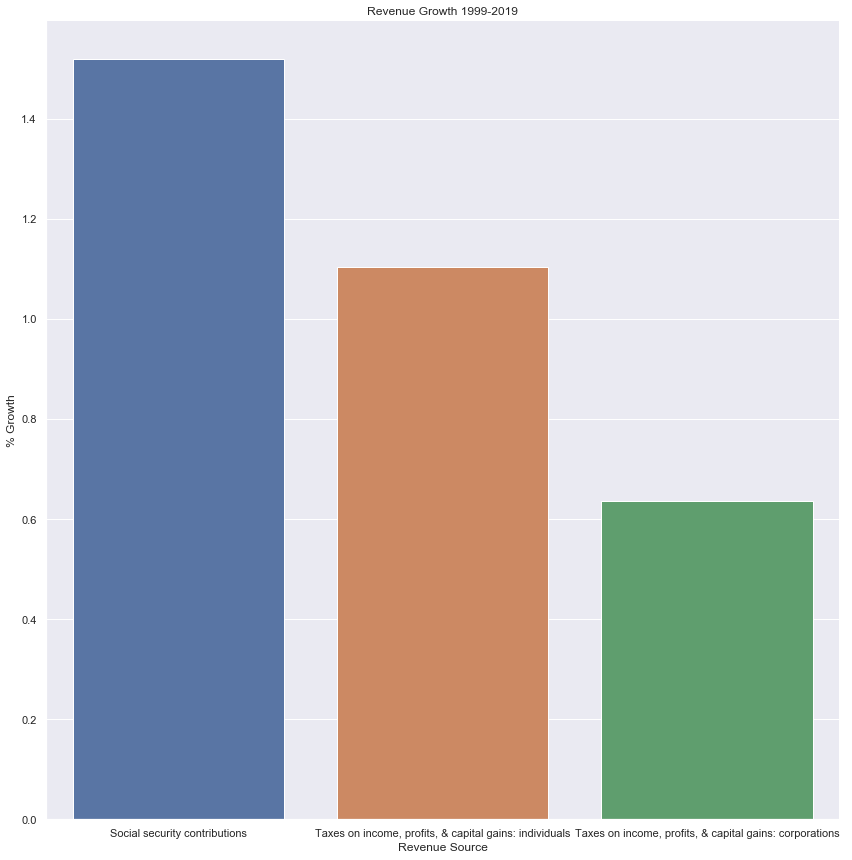

In [11]:
bar_frame = sub_category_group[sub_category_group['year'].isin(['1999', '2019'])]
bar_frame = bar_frame.groupby(['revenue_source'])['value'].agg(last='max', first='min')
bar_frame['perc_increase'] = (bar_frame['last'] - bar_frame['first']) / bar_frame['first']
bar_frame = bar_frame.reset_index()
bar_frame.sort_values(by=['perc_increase'], inplace=True, ascending=False)

g = sns.catplot(kind='bar', x='revenue_source', y='perc_increase', data=bar_frame, height=12)
g.set(xlabel='Revenue Source', ylabel='% Growth', title='Revenue Growth 1999-2019')
g

### Basic Regression

Firstly, lets grab a revenue source and mark it as a the historic set.

In [12]:
ind_tax_frame = melted_frame[melted_frame['revenue_source'] == larger_growers[0]]
ind_tax_frame = ind_tax_frame[['year', 'value']]
ind_tax_frame['is_pred'] = 'Historic'

Now let's fit our simple linear regression model with data and fit it, we can then begin to gather predictions along the regression gradient.

In [13]:
x = ind_tax_frame['year'].values.reshape(-1, 1)
y = ind_tax_frame['value']
future_values = [2020, 2021, 2022, 2023, 2024, 2025]
x_pred = np.array(future_values).reshape(-1,1)

model = lr().fit(x, y)
y_pred = model.predict(x_pred)
y_pred

array([202.83213043, 207.77975   , 212.72736957, 217.67498913,
       222.6226087 , 227.57022826])

Let's plot this predictions and see how looks.

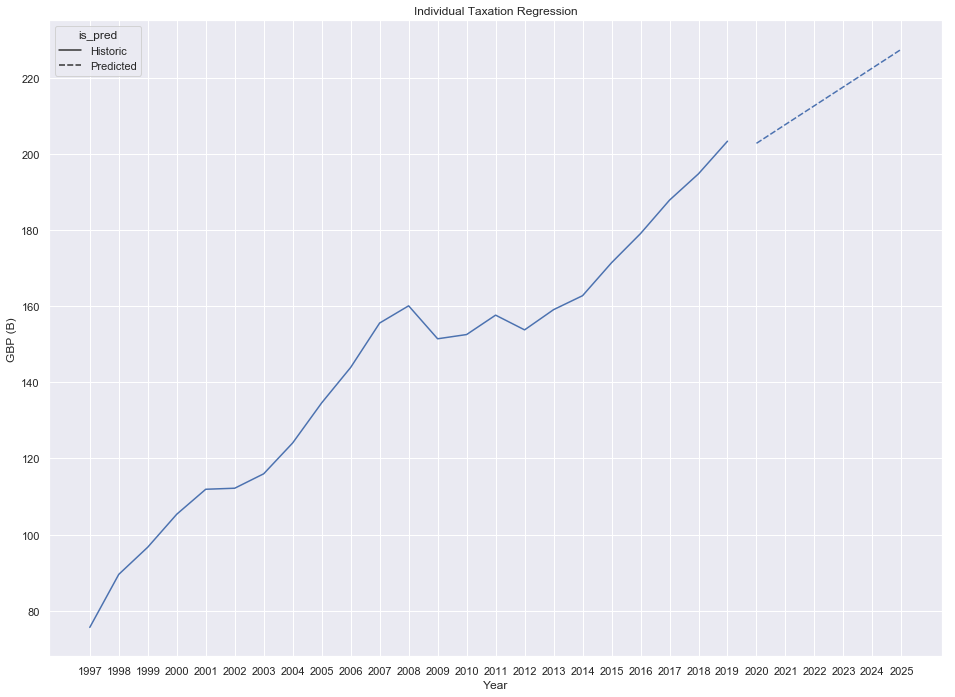

In [14]:
future_frame_dict = {'year': future_values, 'value': y_pred, 'is_pred': ['Predicted'] * 6}
regression_frame = pd.DataFrame.from_dict(future_frame_dict)
regression_frame = pd.concat([ind_tax_frame, regression_frame])
regression_frame['year'] = regression_frame['year'].astype(str)
regression_frame = regression_frame.reset_index()

g = sns.lineplot(x='year', y='value', style='is_pred', data=regression_frame)
g.set(xlabel='Year', ylabel='GBP (B)', title='Individual Taxation Regression')
g

Our regression looks like it's underpredicting, probably due to the dip in the global population income during the 2008 financial crisis. To improve the model, we could remove these points as outliers within the set. As what could be the odds of a major global event happening in 2020 disrupting global economics as we know it?